# UrbanSound8K Dataset - Audio Classification 

---



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/My Drive/MPDL Fall 2020/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Installing right version of the libraries

In [ ]:
! pip install -U pip
! pip install -U torch==1.5.1
! pip install -U torchaudio==0.5.1
! pip install -U torchvision==0.6.1
! pip install -U matplotlib==3.2.1
! pip install -U trains>=0.16.1
! pip install -U pandas==1.0.4
! pip install -U numpy==1.18.4
! pip install -U tensorboard==2.2.1

In [ ]:
import pandas as pd
import numpy as np
from pathlib2 import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchaudio
from torchvision.transforms import ToTensor
from torchvision import models
import librosa.display
import IPython.display as ipd 
from trains import Task
from trains.storage import StorageManager

%matplotlib inline

import PIL
import io

In [ ]:
from sklearn.metrics import accuracy_score

import time

from mpdl import View, train_simple_network, Flatten, weight_reset, set_seed, run_epoch, LastTimeStep, EmbeddingPackable

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Dataset description
**Source** : https://urbansounddataset.weebly.com/urbansound8k.html

**Description** : 

**META-DATA FILES** : UrbanSound8k.csv

This file contains meta-data information about every audio file in the dataset. This includes:

* slice_file_name: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
[classID] = a numeric identifier of the sound class (see description of classID below for further details)
[occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
[sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold number (1-10) to which this file has been allocated.

* **classID:**

A numeric identifier of the sound class:
0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

* class:
The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, 
siren, street_music.

In [ ]:
#Reading the meta data CSV
UrbanSound_csv=pd.read_csv("/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/metadata/UrbanSound8K.csv")

In [ ]:
UrbanSound_csv.head()

slice_file_name    fsID  start  ...  fold  classID             class
0    100032-3-0-0.wav  100032    0.0  ...     5        3          dog_bark
1  100263-2-0-117.wav  100263   58.5  ...     5        2  children_playing
2  100263-2-0-121.wav  100263   60.5  ...     5        2  children_playing
3  100263-2-0-126.wav  100263   63.0  ...     5        2  children_playing
4  100263-2-0-137.wav  100263   68.5  ...     5        2  children_playing

[5 rows x 8 columns]

In [ ]:
UrbanSound_csv.tail()

slice_file_name   fsID       start  ...  fold  classID     class
8727  99812-1-2-0.wav  99812  159.522205  ...     7        1  car_horn
8728  99812-1-3-0.wav  99812  181.142431  ...     7        1  car_horn
8729  99812-1-4-0.wav  99812  242.691902  ...     7        1  car_horn
8730  99812-1-5-0.wav  99812  253.209850  ...     7        1  car_horn
8731  99812-1-6-0.wav  99812  332.289233  ...     7        1  car_horn

[5 rows x 8 columns]

### Fetching out the unique classes from the dataset. Then getting location of one file of each class. 

In [ ]:
unique_classes=list(UrbanSound_csv["class"].unique())

In [ ]:
data_location=dict()
for i in range(len(unique_classes)):
    df=UrbanSound_csv[UrbanSound_csv["class"]==unique_classes[i]].reset_index()
    fold=df["fold"].iloc[0]    # The fold of the first audio sample for the specific class
    name=df["slice_file_name"].iloc[0]
    location="/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/audio/fold{0}/{1}".format(fold, name)
    data_location[unique_classes[i]]=location

In [ ]:
data_location

{'air_conditioner': '/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/audio/fold5/100852-0-0-0.wav',
 'car_horn': '/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/audio/fold10/100648-1-0-0.wav',
 'children_playing': '/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/audio/fold5/100263-2-0-117.wav',
 'dog_bark': '/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/audio/fold5/100032-3-0-0.wav',
 'drilling': '/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/audio/fold3/103199-4-0-0.wav',
 'engine_idling': '/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/audio/fold10/102857-5-0-0.wav',
 'gun_shot': '/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/audio/fold1/102305-6-0-0.wav',
 'jackhammer': '/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/audio/fold1/103074-7-0-0.wav',
 'siren': '/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/audio/fold7/102853-8-0-0.wav',
 'street_music': '/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/audio/fold7/101848-9-0-0.wav'}

# Visualizing the Data

Audio data is generally visualized in the form of waveplots. A waveplot is a graph consisting of two axes. The X axis represents the time, the Y axis represents the displacement from the mean position aka the amplitude. The following lines of code uses the librosa package in python to display a single waveplot for each class. Initially, the path of each audio file is extracted and stored in a dictionary.

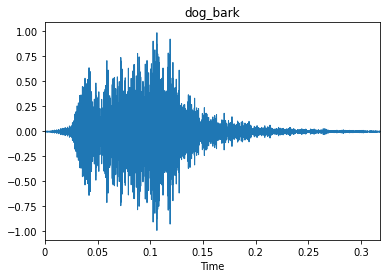

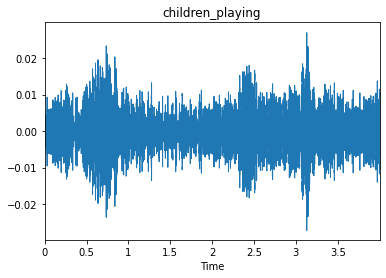

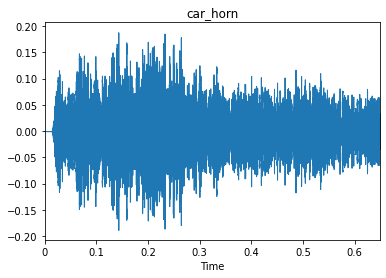

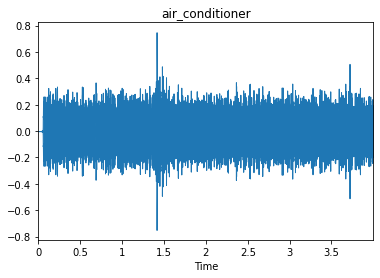

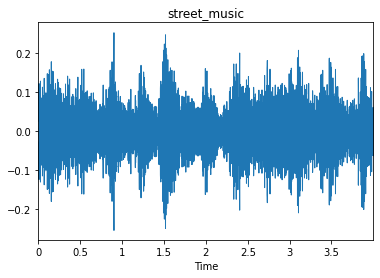

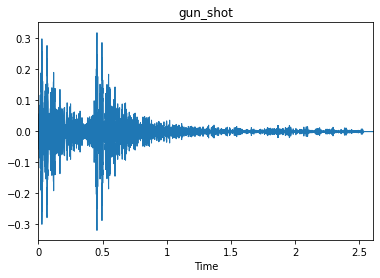

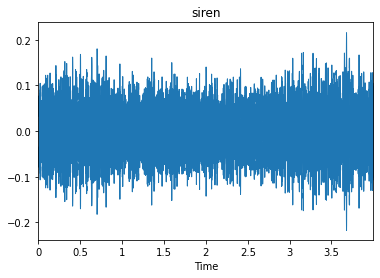

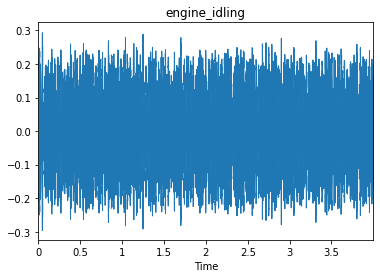

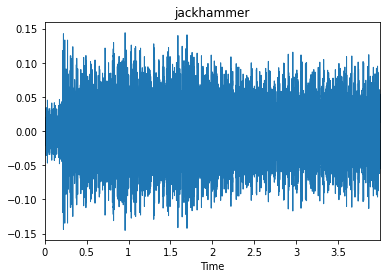

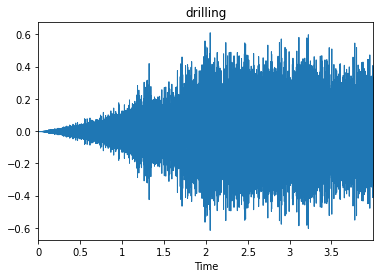

In [ ]:
for i, label in enumerate(unique_classes):
    sample=data_location[label]
    plt.clf()
    plt.title(label)
    data, sample_rate=librosa.load(sample)
    librosa.display.waveplot(data, sr=sample_rate)
    # plt.savefig("outputs/{}.png".format(label))
    plt.show()

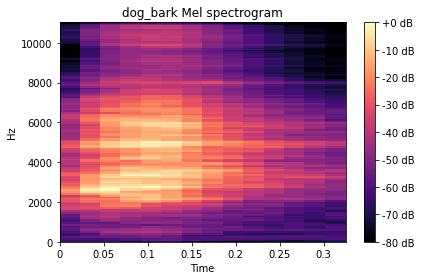

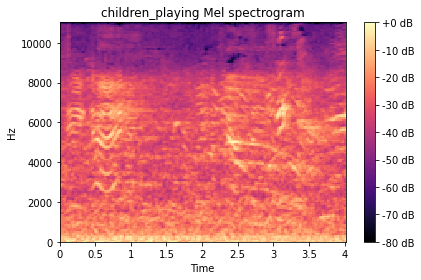

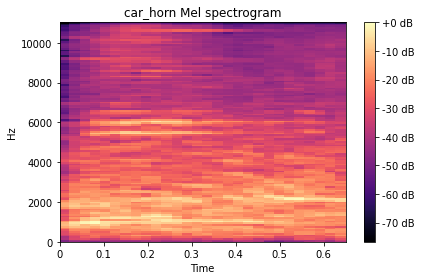

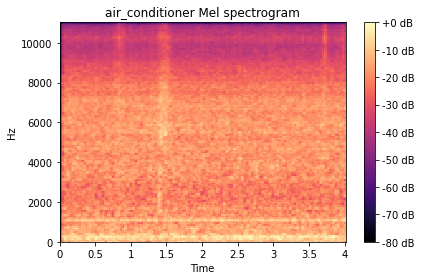

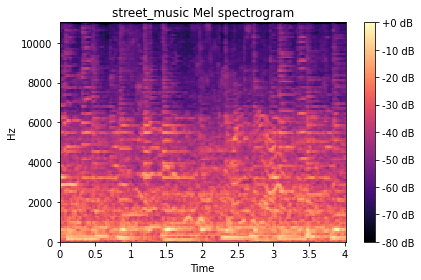

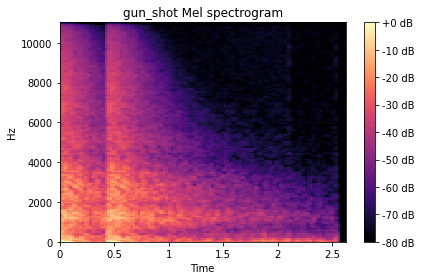

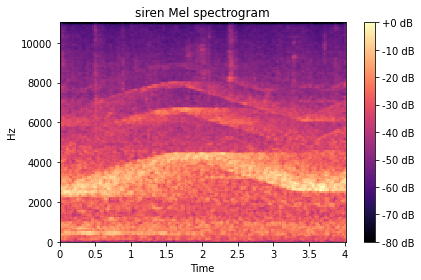

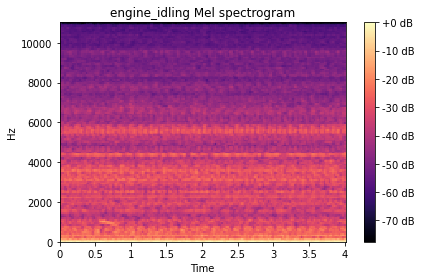

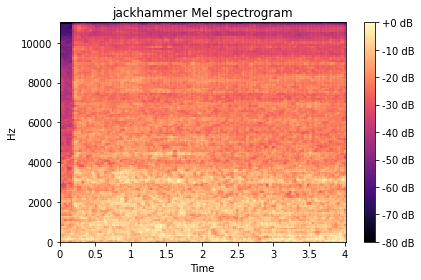

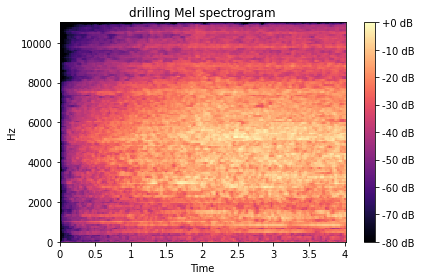

In [ ]:
for i, label in enumerate(unique_classes):
    sample=data_location[label]
    plt.clf()
    plt.title(label)
    x, sr=librosa.load(sample)
    #Reference: https://github.com/sarthak268/Audio_Classification_using_LSTM/blob/master/visualize.py
    X = librosa.feature.melspectrogram(y=x, sr=sr)
    Xdb = librosa.power_to_db(abs(X), ref=np.max)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #plt.savefig('./plt/' + str(i[:-4]) + '.png')
    plt.colorbar(format='%+2.0f dB')
    plt.title('{} Mel spectrogram'.format(label))
    plt.tight_layout()
    # plt.savefig("outputs/{}.png".format(label))
    plt.show()

### Generating features
To feed this audio data to a model, we have to convert it to some numeric form. In ML, audio data is generally converted into Mel Frequency Cepstral Coefficient (MFCC) feature vector. The librosa package is designed to generate these coefficients.

In [ ]:
def extract_mfcc(path):
    audio, sr=librosa.load(path)
    required_file_format=librosa.feature.mfcc(audio, sr, n_mfcc=40)
    return np.mean(required_file_format.T, axis=0)

In [ ]:
path=data_location['drilling']
path

'/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/audio/fold3/103199-4-0-0.wav'

saving each audio in the form of numeric data into drive

In [ ]:
features=[]
labels=[]
folds=[]
for i in range(len(UrbanSound_csv)):
    fold=UrbanSound_csv["fold"].iloc[i]
    filename=UrbanSound_csv["slice_file_name"].iloc[i]
    location="/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/audio/fold{0}/{1}".format(fold, filename)
    required_file_format=extract_mfcc(location)
    features.append(required_file_format)
    folds.append(fold)
    labels.append(UrbanSound_csv["classID"].iloc[i])
features=torch.tensor(features, dtype=torch.float)
labels=torch.tensor(labels, dtype=torch.float)
folds=torch.tensor(folds, dtype=torch.float)
# Saving the dataset to disk to prevent re-Loading
torch.save(features, "/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/features_mfccs.pt")
torch.save(labels, "/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/labels.pt")
torch.save(folds, "/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/folds.pt")

The features, labels and folds are stored in the drive as it takes lot of time to get the features. 

In [ ]:
features=torch.load("/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/features_mfccs.pt")
labels=torch.load("/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/labels.pt")
folds=torch.load("/content/gdrive/MyDrive/MPDL Fall 2020/UrbanSound8K/folds.pt")

### Converting labels into required type


In [ ]:
labels=torch.tensor(labels, dtype=torch.long)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [ ]:
print('alive')

alive


## Defining the dataset.

In [ ]:
dataset=TensorDataset(features, labels)

In [ ]:
dataset

### reference chapter 5: 

train_sub_set, val_sub_set = torch.utils.data.random_split(dataset_trial, [int(len(dataset_trial)*0.8), int(len(dataset_trial)*0.2)])

Dividing the dataset into train and test sets.

In [ ]:
test_size=int(0.2*len(dataset))
train_size=int(len(dataset)-test_size)

train, test=torch.utils.data.random_split(dataset, [train_size, test_size])

print(len(train))
print(len(test))

6986
1746


In [ ]:
train[0]

(tensor([-2.3644e+02,  9.6972e+01, -1.5343e+01,  3.5459e+01, -2.6975e+01,
          1.1089e+01, -1.2773e+01, -9.8961e+00, -5.8332e+00, -5.4571e-01,
         -1.2674e+01, -1.8356e+00, -1.0044e+01,  6.0897e+00, -4.6887e+00,
          5.2216e+00, -7.7704e+00, -5.6875e+00, -1.4985e+01, -1.1668e+00,
         -7.7303e+00,  7.2951e-01, -3.8120e+00,  1.1631e+00, -5.4681e+00,
         -1.0212e+00, -6.6823e+00,  2.1851e+00, -2.9682e+00,  2.7235e+00,
         -5.9259e+00, -1.4404e+00, -4.0718e+00,  1.3652e-01, -1.7051e+00,
          3.1410e+00,  1.6071e+00,  1.6920e+00, -2.5480e+00, -1.6664e+00]),
 tensor(0))

## Defining the train and test loader

In [ ]:
batch_size=12
train_loader=DataLoader(train, batch_size, shuffle=True)
test_loader=DataLoader(test, batch_size, shuffle=False)

The input dimension and the number of classes.

In [ ]:
in_=40
classes=10

# Defining various models and comparing the results.

## Simple Linear Model

In [ ]:
simple_linear_model = nn.Sequential(
    nn.Linear(in_,  128),
    nn.Tanh(),
    nn.Linear(128,  256),
    nn.Tanh(),
    nn.Linear(256, classes),
)

In [ ]:
from tqdm.autonotebook import tqdm

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
simple_linear_model_results=train_simple_network(simple_linear_model, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

# Fully connected layer.

In [ ]:
model = nn.Sequential(
    nn.Linear(in_,  128),
    nn.Tanh(),
    nn.Linear(128,  128),
    nn.Tanh(),
    nn.Linear(128, classes),
)
fc_results = train_simple_network(model, loss_func, train_loader, epochs=20, 
                                  val_loader=test_loader, 
                                  checkpoint_file='model.pt', 
                                  score_funcs={'Acc':accuracy_score})

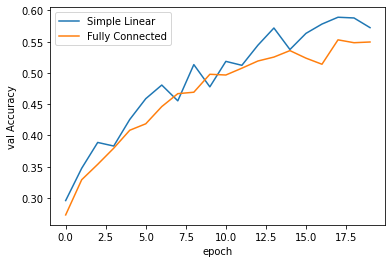

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=simple_linear_model_results, label='Simple Linear')
sns.lineplot(x='epoch', y='val Acc', data=fc_results, label='Fully Connected')

## Extending the linear model and adding Relu activation function

In [ ]:
simple_linear_model_extended = nn.Sequential(
    
        nn.Linear(in_,128),

        nn.ReLU(),

        nn.Linear(128, 128),
        nn.ReLU(),

        nn.Linear(128,128),
        nn.ReLU(),

        nn.Linear(128, 128),
        nn.ReLU(),

        nn.Linear(128,256),
        nn.ReLU(),

        nn.Linear(256, 256),
        nn.ReLU(),

        nn.Linear(256,256),
        nn.ReLU(),

        nn.Linear(256, 128),
        nn.ReLU(),

        nn.Linear(128,128),
        nn.ReLU(),

        nn.Linear(128, 64),
        nn.ReLU(),

        nn.Linear(64,classes)
)

In [ ]:
simple_linear_model_extended_results=train_simple_network(simple_linear_model_extended, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

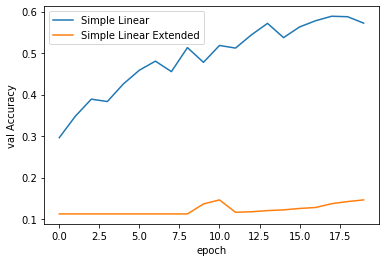

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=simple_linear_model_results, label='Simple Linear')
sns.lineplot(x='epoch', y='val Accuracy', data=simple_linear_model_extended_results, label='Simple Linear Extended')

# Observation
The above graph shows that the model with RELU activation is performing worse. The normal model with TanH activation is performing much better. Even though the extended model is deeper and has so many layers, still the model's accuracy is very low.

In [ ]:
n_filters=64

## Convolutional Network

In [ ]:
cnn_model = nn.Sequential(
    # https://stackoverflow.com/questions/64944278/runtimeerror-input-must-have-3-dimensions-got-2
    View(-1,40,1,1),
    nn.Conv2d(in_, n_filters, (3,3), padding=1), 
    nn.Tanh(),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.Tanh(),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    #nn.MaxPool2d((2,2)),
    nn.Tanh(),
    nn.Conv2d(n_filters, 2*n_filters, (3,3), padding=1), 
    nn.Tanh(),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.Tanh(),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    #nn.MaxPool2d((2,2)),
    nn.Tanh(),
    nn.Conv2d(2*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.Tanh(),
    nn.Conv2d(4*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.Tanh(),
    Flatten(),
    nn.Linear(4*n_filters, classes),
)

In [ ]:
cnn_model_results=train_simple_network(cnn_model, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

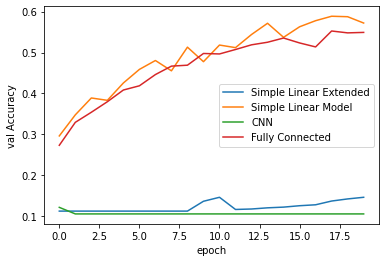

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=simple_linear_model_extended_results, label='Simple Linear Extended')
sns.lineplot(x='epoch', y='val Accuracy', data=simple_linear_model_results, label='Simple Linear Model')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_model_results, label='CNN')
sns.lineplot(x='epoch', y='val Acc', data=fc_results, label='Fully Connected')

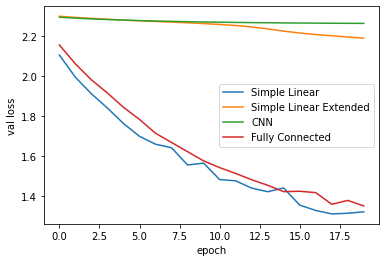

In [ ]:
sns.lineplot(x='epoch', y='val loss', data=simple_linear_model_results, label='Simple Linear')
sns.lineplot(x='epoch', y='val loss', data=simple_linear_model_extended_results, label='Simple Linear Extended')
sns.lineplot(x='epoch', y='val loss', data=cnn_model_results, label='CNN')
sns.lineplot(x='epoch', y='val loss', data=fc_results, label='Fully Connected')

Both of the above graph proves that the simpler linear layer is working the best amongts the Convolution Neural Network, Fully Connected Network, and extended Simple linear model. The highest accuracy is achieved by Simple Linear model and the value being 60%.

The reason behind CNN to under-perform is that sound is transparent, so descrete sound doesnt seperate into layers, therefore, all sum up together into whole so particular frequency cant be assumed to belong to a single sound and makes it difficult to seperate.

We couldnt apply Residual Block because it was giving the shape as 0X0 in the final step leaving us with no dimension

## Long Short Term Memory RNNs

There are a lot of variants of RNNs but one that performs well under every condition is called Long Short Term Memory (LSTM). It overcomes the part where in every time step the model looses some information. 

In [ ]:
features_rnn=torch.tensor(features, dtype=torch.long)
labels_rnn=torch.tensor(labels, dtype=torch.long)
folds_rnn=torch.tensor(folds, dtype=torch.long)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
in_=torch.tensor(in_, dtype=torch.long)

First, we are showing how RNN with 3 layers works on our data.

In [ ]:
rnn_3layer = nn.Sequential(
  
  View(-1,1,40), #reshaping the data into 3 dimensional
  nn.RNN(40, 256, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(256, classes), #(B, D) -> (B, classes)
)

rnn_3layer.to(device)

Sequential(
  (0): View()
  (1): RNN(40, 256, num_layers=3, batch_first=True)
  (2): LastTimeStep()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
dataset_rnn=TensorDataset(features_rnn, labels_rnn)

In [ ]:
test_size=int(0.2*len(dataset_rnn))
train_size=int(len(dataset_rnn)-test_size)

train_rnn, test_rnn=torch.utils.data.random_split(dataset, [train_size, test_size])

len(train_rnn), len(test_rnn)

(6986, 1746)

In [ ]:
batch_size=12
train_loader_rnn=DataLoader(train_rnn, batch_size, shuffle=True)
test_loader_rnn=DataLoader(test_rnn, batch_size, shuffle=False)

In [ ]:
rnn_results = train_simple_network(rnn_3layer, loss_func, train_loader_rnn, val_loader=test_loader_rnn, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

### We dont have to use embedding layer because we are not training on words

Second, we are showing here how drastically the accuracy increases when LSTM is added to the model.

In [ ]:
lstm_3layer = nn.Sequential(
  
  View(-1,1,40), #reshaping the data into 3 dimensional
  nn.LSTM(40, 256, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(256, classes), #(B, D) -> (B, classes)
)

lstm_3layer.to(device)

for p in lstm_3layer.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5))

lstm_results = train_simple_network(lstm_3layer, loss_func, train_loader_rnn, val_loader=test_loader_rnn, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

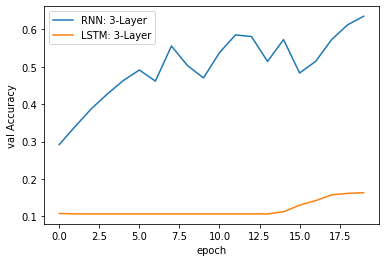

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_results, label='RNN: 3-Layer')
sns.lineplot(x='epoch', y='val Accuracy', data=lstm_results, label='LSTM: 3-Layer')

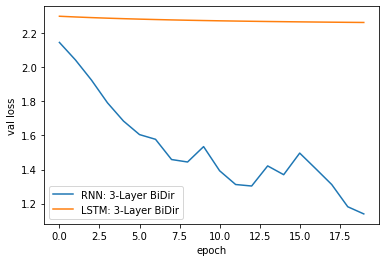

In [ ]:
sns.lineplot(x='epoch', y='val loss', data=rnn_results, label='RNN: 3-Layer BiDir')
sns.lineplot(x='epoch', y='val loss', data=lstm_results, label='LSTM: 3-Layer BiDir')

## Batch Normalization

SO far the models had only the layers with activation functions. Now changing the design of the architecture and adding BatchNormalization layer in both the CNN and Fully Connected model. 

In [ ]:
leak_rate=0.1

In [ ]:
cnn_bn_model = nn.Sequential(
    View(-1,40,1,1),
    nn.Conv2d(in_, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(n_filters, n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(n_filters),
    #nn.MaxPool2d(2),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(n_filters, 2*n_filters, (3,3), padding=1),
    nn.BatchNorm2d(2*n_filters), 
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(2*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(2*n_filters, 2*n_filters, (3,3), padding=1), 
    #nn.MaxPool2d(2),
    nn.BatchNorm2d(2*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(2*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(4*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Conv2d(4*n_filters, 4*n_filters, (3,3), padding=1), 
    nn.BatchNorm2d(4*n_filters),
    nn.LeakyReLU(leak_rate),
    Flatten(),
    nn.Linear(4*n_filters, classes),
)

In [ ]:
cnn_bn_results = train_simple_network(cnn_bn_model, loss_func, train_loader, val_loader=test_loader, epochs=20, score_funcs={'Accuracy': accuracy_score}, device=device)


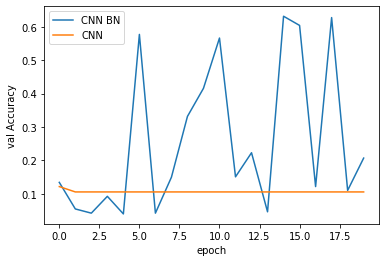

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_bn_results, label='CNN BN')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_model_results, label='CNN')

normalizing helps to ensure our literal numeric values after each layer are in a generically "good" range, and through $\gamma$ and $\beta$ the network can _decide_ where precisely that range is.

From the above figure, we can clearly say that adding the Batch Normalization to the network increases the accuracy of the model drastically. There is much difference between the accuracy of normal CNN and CNN with BatchNorm layers. The normal CNN was performing very poorly, with accuracy of around 10%. The BatchNorm layers have helped and spiked up the accuracy to 60%.
# Normalization layer adds a magical touch.
The next tool we are going to learn about is called a _normalization layer_. Normalization layers are unique because they don't make a neural network any "stronger". If you had two networks _A_ and _B_, where the only difference between them was _A_ had normalization layers but _B_ does not, theoretically _A_ and _B_ are _equally capable_ of learning the _exact_ same thing. There is no function that _A_ could learn but _B_ could not, and vice versa. And yet, normalization layers have become frustratingly successful. In many ways they act like a kind of "magic pixie dust",  you sprinkle it into your neural network and suddenly it converges faster to better solutions than before! They even help networks that would not train well at all before suddenly become top contenders in terms of accuracy and results. (Chapter 6)

In [ ]:
n=128

In [ ]:
fc_bn_model = nn.Sequential(
    Flatten(),
    nn.Linear(in_,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n,  n),
    nn.BatchNorm1d(n),
    nn.LeakyReLU(leak_rate),
    nn.Linear(n, classes),
)


In [ ]:
fc_bn_results = train_simple_network(fc_bn_model, loss_func, train_loader, val_loader=test_loader, epochs=20, score_funcs={'Accuracy': accuracy_score}, device=device)


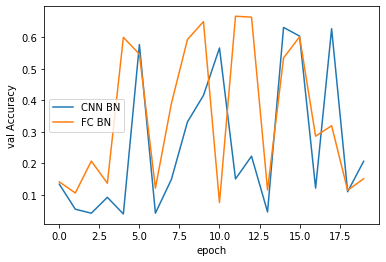

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_bn_results, label='CNN BN')
sns.lineplot(x='epoch', y='val Accuracy', data=fc_bn_results, label='FC BN')

It is evident from the above graph that Fully connected model with Batch Normalization layer is performing better than the Convolution Neural Network in the mid epochs but decreases suddenly at the end leaving CNN to perform better in the final layers with Batch Normalization layer.

In [ ]:
fc_bn_results

epoch  total time  train loss     val loss  train Accuracy  val Accuracy
0       0    6.605852    2.028199     8.146667        0.295305      0.141466
1       1   12.382818    1.756266  1021.064133        0.416834      0.105956
2       2   18.018566    1.644356     9.219773        0.452333      0.207331
3       3   24.063971    1.557191   156.299993        0.481391      0.136884
4       4   29.792758    1.484063     1.378730        0.511595      0.600229
5       5   35.346450    1.408624     1.383574        0.528915      0.546964
6       6   40.921187    1.355229   279.925596        0.548096      0.121420
7       7   46.603953    1.427807     2.035075        0.518322      0.390607
8       8   52.264376    1.351490     1.252642        0.546951      0.593356
9       9   57.860115    1.298517     1.124419        0.566705      0.650057
10     10   63.413791    1.267054    11.628562        0.571285      0.075601
11     11   69.021827    1.264756     1.124503        0.572431      0.667239
12     12   74.666366    1.204093     1.103393        0.602348      0.664376
13     13   80.225525    1.163066   175.419888        0.617378      0.115693
14     14   85.813016    1.246494     1.385317        0.583166      0.534937
15     15   91.569169    1.199908     1.260194        0.595334      0.601947
16     16   97.104745    1.169184     4.232032        0.609934      0.286369
17     17  102.874374    1.131504     2.847466        0.623819      0.319588
18     18  108.571625    1.152884   159.805959        0.617234      0.114548
19     19  114.089777    1.193127     8.647069        0.599342      0.151203

# Conclusion

Form the beging of the notebook, it is evident that the simple linear layer is performing better than Fully Connected Layers and Convolution Neural Networks. The highest accuracy reached by any model is 70%. All the models were fast and thus the computational resources were required less and the time to train the models are also average.  